In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load neccessary libraries
import os
import warnings
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from utils.misc import download_and_unzip_file
from utils.sound_utils import load_sound_file

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
warnings.filterwarnings("ignore")
plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [4]:
DATA_PATH = "../../data/mimii-anomaly-detection"
IMAGE_PATH = "./img"
FILE_NAMES = [
    "-6_dB_fan",
    "-6_dB_valve",
    "-6_dB_pump",
    "-6_dB_slider",
    "6_dB_fan",
    "6_dB_valve",
    "6_dB_pump",
    "6_dB_slider",
    "0_dB_fan",
    "0_dB_pump",
    "0_dB_valve",
    "0_dB_slider",
]

file_names = [FILE_NAMES[4]]  # only the fans
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)

for file_name in file_names:
    download_and_unzip_file(DATA_PATH, file_name)

Sound files found, no need to download them again.


In [5]:
normal_signal_file = os.path.join(
    DATA_PATH, "6dB", "fan", "id_00", "normal", "00000103.wav"
)  # only one pair of sound clips selected
abnormal_signal_file = os.path.join(
    DATA_PATH, "6dB", "fan", "id_00", "abnormal", "00000103.wav"
)
normal_signal, _ = load_sound_file(normal_signal_file)
abnormal_signal, sr = load_sound_file(abnormal_signal_file)

print(
    f"The signals have a {normal_signal.shape} shape. At {sr} Hz, these are {normal_signal.shape[0] / sr:.0f}s signals."
)

The signals have a (160000,) shape. At 16000 Hz, these are 10s signals.


In [6]:
# Load an audio file as a floating point time series
# sr (target sampling rate) - ‘None’ uses the native sampling rate
signal, sr = librosa.load(normal_signal_file, sr=None, mono=False)
signal.shape, sr

((8, 160000), 16000)

In [7]:
signal.ndim < 2

False

In [8]:
channel=0
sound_file = signal[channel, :], sr
sound_file

(array([0.00747681, 0.00909424, 0.01010132, ..., 0.00942993, 0.00961304,
        0.00878906], dtype=float32),
 16000)

In [9]:
def load_sound_file(path, mono=False, channel=0):
    #Load an audio file as a floating point time series
    signal, sr = librosa.load(path, sr=None, mono=mono)
    # Check if signal is mono 
    if signal.ndim < 2:
        sound_file = signal, sr
    else:
        sound_file = signal[channel, :], sr

    return sound_file

In [10]:
IPython.display.Audio(normal_signal_file, rate=sr)

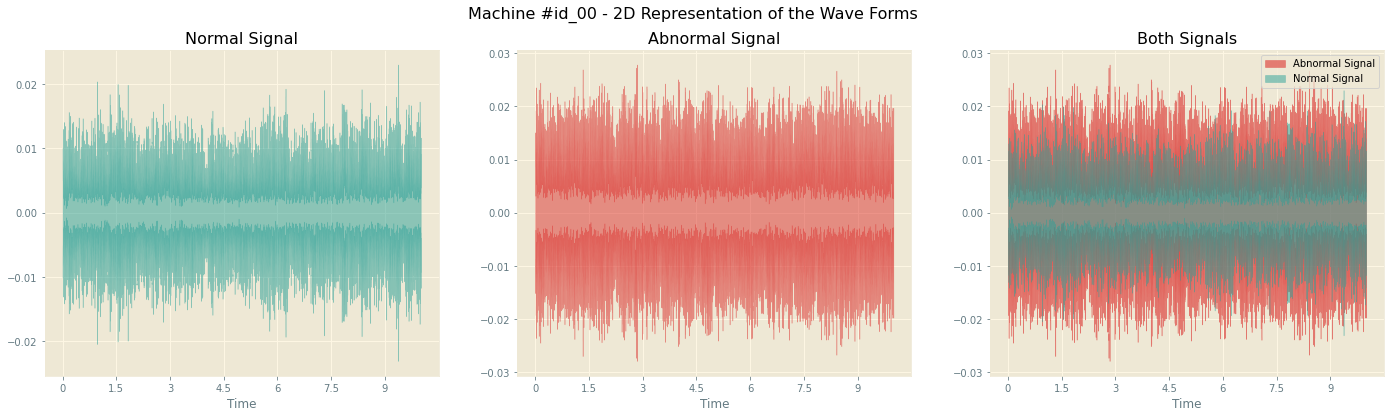

In [11]:
import librosa.display
fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
# Visualize a waveform in the time domain.
librosa.display.waveshow(
    # audio time series (mono or stereo)
    normal_signal,
    # sampling rate of y (samples per second)
    sr=sr,
    # color intensity
    alpha=0.5,
    color=colors[1],
    linewidth=0.5,
    label="Machine #id_00 - Normal Signal",
)
plt.title("Normal Signal")

plt.subplot(1, 3, 2)
librosa.display.waveshow(
    abnormal_signal,
    sr=sr,
    alpha=0.5,
    color=colors[5],
    linewidth=0.5,
    label="Machine #id_00 - Abnormal Signal",
)
plt.title("Abnormal Signal")

plt.subplot(1, 3, 3)
librosa.display.waveshow(
    abnormal_signal,
    sr=sr,
    alpha=0.6,
    color=colors[5],
    linewidth=0.5,
    label="Abnormal Signal",
)
librosa.display.waveshow(
    normal_signal,
    sr=sr,
    alpha=0.5,
    color=colors[1],
    linewidth=0.5,
    label="Normal Signal",
)
plt.title("Both Signals")

fig.suptitle("Machine #id_00 - 2D Representation of the Wave Forms", fontsize=16)
plt.legend()
plt.show()
#fig.savefig(os.path.join(IMAGE_PATH, "wave_forms.svg"), format="svg")

### Short Time Fourier Tranform
Short-time Fourier transform (STFT) is a sequence of Fourier transforms of a windowed signal. STFT provides the time-localized frequency information for situations in which frequency components of a signal vary over time, whereas the standard Fourier transform provides the frequency information averaged over the entire signal time interval.

In [12]:
len(normal_signal[:2048]), normal_signal

(2048,
 array([0.00747681, 0.00909424, 0.01010132, ..., 0.00942993, 0.00961304,
        0.00878906], dtype=float32))

In [13]:
n_fft = 2048
# https://librosa.org/doc/main/generated/librosa.stft.html
normal_stft = np.abs(
    librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1)
)
abnormal_stft = np.abs(
    librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1)
)

normal_stft.shape

(1025, 1)

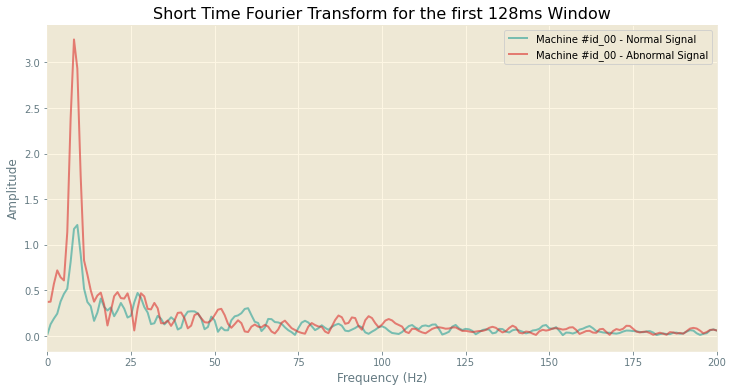

In [14]:
fig = plt.figure(figsize=(12, 6))
# https://librosa.org/doc/main/generated/librosa.stft.html
plt.plot(
    normal_stft, color=colors[1], alpha=0.6, label="Machine #id_00 - Normal Signal"
)
plt.plot(
    abnormal_stft, color=colors[5], alpha=0.6, label="Machine #id_00 - Abnormal Signal"
)
plt.title(
    f"Short Time Fourier Transform for the first {n_fft / sr * 1000:.0f}ms Window"
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(0, 200)
plt.show()
#fig.savefig(os.path.join(IMAGE_PATH, "stft.svg"), format="svg")

### Spectrograms (dB scale)
A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.

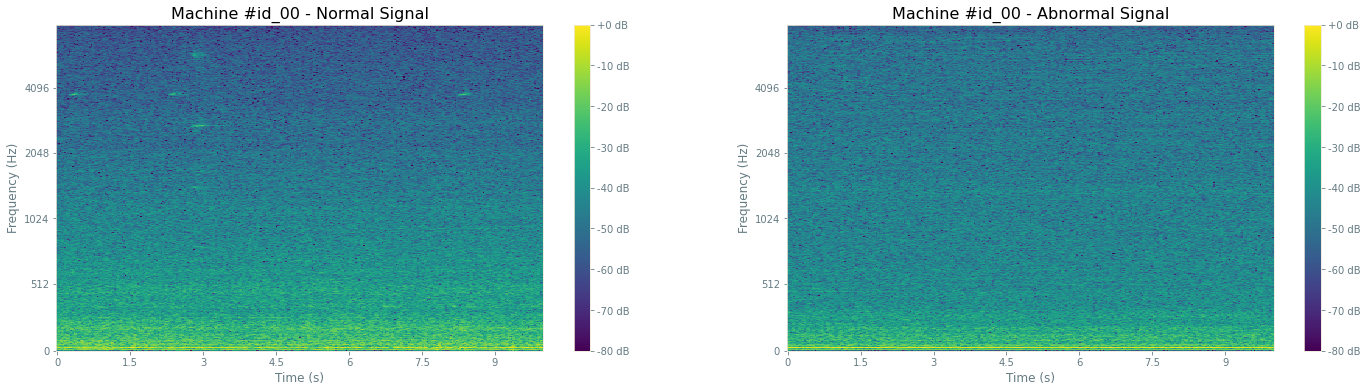

The spectrograms have a (1025, 313) shape.


In [15]:
hop_length = 512
normal_stft = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
# https://librosa.org/doc/main/generated/librosa.amplitude_to_db.html
normal_spectrogram = librosa.amplitude_to_db(normal_stft, ref=np.max)
abnormal_stft = np.abs(
    librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length)
)
abnormal_spectrogram = librosa.amplitude_to_db(abnormal_stft, ref=np.max)

fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
# https://librosa.org/doc/main/generated/librosa.display.specshow.html
librosa.display.specshow(
    normal_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis"
)
plt.title("Machine #id_00 - Normal Signal")
plt.colorbar(format="%+2.f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.subplot(1, 2, 2)
librosa.display.specshow(
    abnormal_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis"
)
plt.title("Machine #id_00 - Abnormal Signal")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "spectrograms.svg"), format="svg")

print(f"The spectrograms have a {normal_spectrogram.shape} shape.")

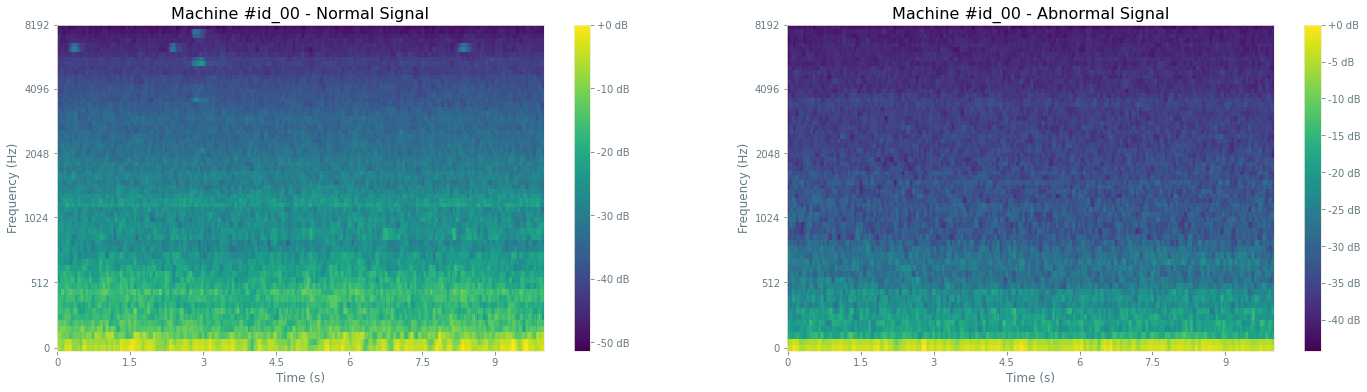

The mel-spectrograms have a (64, 313) shape.


In [16]:
n_mels = 64
# https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
normal_mel_spectrogram = librosa.feature.melspectrogram(
    normal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
normal_mel_spectrogram = librosa.power_to_db(normal_mel_spectrogram, ref=np.max)
abnormal_mel_spectrogram = librosa.feature.melspectrogram(
    abnormal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
abnormal_mel_spectrogram = librosa.power_to_db(abnormal_mel_spectrogram, ref=np.max)

fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(
    normal_mel_spectrogram,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
)
plt.title("Machine #id_00 - Normal Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.0f dB")

plt.subplot(1, 2, 2)
librosa.display.specshow(
    abnormal_mel_spectrogram,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel",
    cmap="viridis",
)
plt.title("Machine #id_00 - Abnormal Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.0f dB")

plt.show()
#fig.savefig(os.path.join(IMAGE_PATH, "mel_spectrograms.svg"), format="svg")

print(f"The mel-spectrograms have a {normal_mel_spectrogram.shape} shape.")

### Multiple Frames of Spectrograms

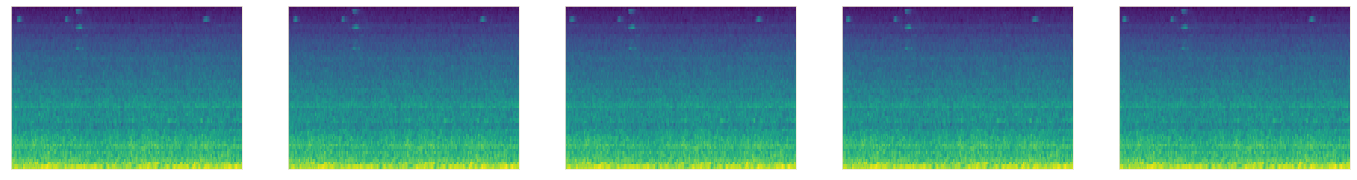

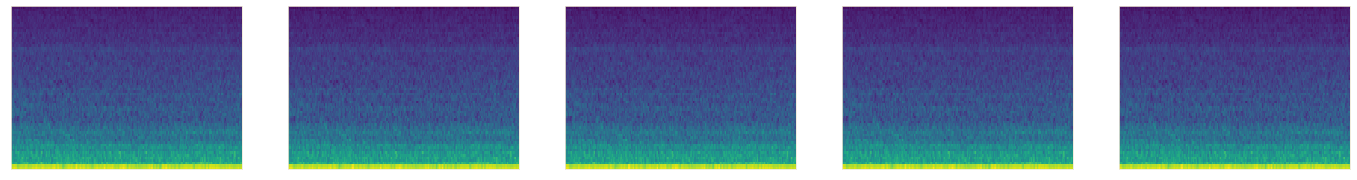

The features have a (309, 320) shape.


In [17]:
frames = 5
dims = frames * n_mels

features_vector_size = normal_mel_spectrogram.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t : n_mels * (t + 1)] = normal_mel_spectrogram[
        :, t : t + features_vector_size
    ].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(
        features[:, n_mels * t : n_mels * (t + 1)].T,
        sr=sr,
        hop_length=hop_length,
        cmap="viridis",
    )
fig.savefig(os.path.join(IMAGE_PATH, "normal_frames.svg"), format="svg")

features_vector_size = abnormal_mel_spectrogram.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t : n_mels * (t + 1)] = abnormal_mel_spectrogram[
        :, t : t + features_vector_size
    ].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(
        features[:, n_mels * t : n_mels * (t + 1)].T,
        sr=sr,
        hop_length=hop_length,
        cmap="viridis",
    )

plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "abnormal_frames.svg"), format="svg")

print(f"The features have a {features.shape} shape.")

In [7]:
# Load neccessary libraries
import os
import warnings
import IPython.display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from utils.misc import download_and_unzip_file
from utils.sound_utils import load_sound_file

In [8]:
import glob
import os
import warnings
import numpy as np
from bokeh.io import export_svgs, output_notebook
from bokeh.models import BoxAnnotation, ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from utils.measuring_performance import (
    get_prediction,
    plot_confusion_matrix,
    plot_histogram_by_class,
    plot_loss_per_epoch,
    plot_pr_curve,
    plot_roc_curve,
)
from utils.misc import build_files_list, dump_pickle, load_pickle
from utils.sound_utils import extract_signal_features, generate_dataset, load_sound_file

output_notebook()
warnings.filterwarnings("ignore")
np.random.seed(42)

Loading BokehJS ...

In [9]:
warnings.filterwarnings("ignore")
plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [10]:
# Specify path to the folders
DATA_PATH = "../../data/mimii-anomaly-detection"
IMAGE_PATH = "./img"
MODEL_PATH = "./models"
MERGE_MACHINE_ID = True

os.makedirs(os.path.join(DATA_PATH, "dataset"), exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

file_paths = sorted(
    glob.glob(DATA_PATH + "/*/*" if MERGE_MACHINE_ID else DATA_PATH + "/*/*/*")
)

In [11]:
file_path = file_paths[0]  # the first machine ID or machine type selected
file_path_split = file_path.split("/")
SUFFIX = "_".join(["", file_path_split[-1], file_path_split[-2]])

if MERGE_MACHINE_ID:
    print(f"db: {file_path_split[-2]}, machine type: {file_path_split[-1]}")

else:
    print(
        f"db: {file_path_split[-3]}, machine type: {file_path_split[-2]}, machine id: {file_path_split[-1]}"
    )
    SUFFIX = "_".join([SUFFIX, file_path_split[-3]])

db: 6dB, machine type: fan


In [12]:
normal_files, abnormal_files = build_files_list(root_dir=file_path)
normal_labels = np.zeros(len(normal_files))
abnormal_labels = np.ones(len(abnormal_files))
print(normal_labels)
print(abnormal_labels)

[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


In [13]:
len(normal_files), len(abnormal_files)

(4075, 1475)

In [39]:
for index, file in enumerate(abnormal_files):
    if(Path(file).stem == "00000001"):
        print("Numero uno")
        print(Path(file).stem)
        print(file.split("/")[-3])
        print(file)
        print(index)
        print(file.split("/")[-3] + "_" + Path(file).stem)
    #print(Path(file).stem)

Numero uno
00000001
id_06
../../data/mimii-anomaly-detection/6dB/fan/id_06/abnormal/00000001.wav
11
id_06_00000001
Numero uno
00000001
id_04
../../data/mimii-anomaly-detection/6dB/fan/id_04/abnormal/00000001.wav
371
id_04_00000001
Numero uno
00000001
id_00
../../data/mimii-anomaly-detection/6dB/fan/id_00/abnormal/00000001.wav
724
id_00_00000001
Numero uno
00000001
id_02
../../data/mimii-anomaly-detection/6dB/fan/id_02/abnormal/00000001.wav
1127
id_02_00000001


In [37]:
from pathlib import Path
# this is the number of samples in a window per fft
n_fft = 2048
# The amount of samples we are shifting after each fft
hop_length = 512
# number of Mel bands to generate
n_mels = 64
frames = 5

In [55]:
len(abnormal_files)

1475

In [58]:
out = "/home/iotg/work/SWA/SWA/data/mimii-anomaly-detection/dataset_cnn/6db/abnormal/"

for file in tqdm(abnormal_files[1350:len(abnormal_files)]):
    signal, sr = load_sound_file(file)
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    ax = plt.axes()
    ax.set_axis_off()
    librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='hz', hop_length=hop_length, cmap='magma')
    img_path = out + file.split("/")[-3] + "_" + Path(file).stem + ".png"
    plt.savefig(img_path, bbox_inches='tight', transparent=True, pad_inches=0.0)
    plt.close()

  0%|          | 0/125 [00:00<?, ?it/s]